# Observationally-based estimates of Southern Ocean air-sea fluxes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import emergent_constraint as ec
import figure_panels
import models
import obs_surface
import util

In [3]:
clobber = False
clobber_deep = False
air_parms = ec.get_parameters('default')

obj_srf = {}; obj_air = {};
acs = {}; scs = {};
for constraint_type in ['ocean_constraint', 'total_constraint',]:
    model_input_lists = ec.get_model_tracer_lists(constraint_type)
    obj_srf[constraint_type] = ec.whole_enchilada_srf(**model_input_lists)
    obj_air[constraint_type] = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)
    
    acs[constraint_type] = obj_air[constraint_type].get_ac(**air_parms, clobber=clobber)
    scs[constraint_type] = obj_srf[constraint_type].get_sc(clobber=clobber)

In [4]:
constraint_type = 'ocean_constraint'
model_input_lists = ec.get_model_tracer_lists(constraint_type)
model_input_lists

{'model_tracer_list': [('CT2017', 'CO2_OCN'),
  ('CT2019B', 'CO2_OCN'),
  ('CTE2018', 'CO2_OCN'),
  ('CTE2020', 'CO2_OCN'),
  ('MIROC', 'CO2_OCN'),
  ('CAMSv20r1', 'CO2_OCN'),
  ('s99oc_v2020', 'CO2_OCN'),
  ('s99oc_ADJocI40S_v2020', 'CO2_OCN'),
  ('s99oc_SOCCOM_v2020', 'CO2_OCN'),
  ('TM5-Flux-m0f', 'CO2_OCN'),
  ('TM5-Flux-mmf', 'CO2_OCN'),
  ('TM5-Flux-mrf', 'CO2_OCN'),
  ('TM5-Flux-mwf', 'CO2_OCN')],
 'model_tracer_ext_list': [('CT2017', 'CO2_LND+CO2_FFF'),
  ('CT2019B', 'CO2_LND+CO2_FFF'),
  ('CTE2018', 'CO2_LND+CO2_FFF'),
  ('CTE2020', 'CO2_LND+CO2_FFF'),
  ('CAMSv20r1', 'CO2_LND+CO2_FFF'),
  ('s99oc_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_ADJocI40S_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_SOCCOM_v2020', 'CO2_LND+CO2_FFF')],
 'model_list_sfco2_lnd': []}

In [5]:
sfco2_ocn_inversions = []
for m, t in model_input_lists['model_tracer_list']:
    if not any(s in m for s in ['TM5', 'CESM', 'prior']) and m not in sfco2_ocn_inversions:
        sfco2_ocn_inversions.append(m)

sfco2_ocn_soccom = [
    'TM5-Flux-m0f', 'TM5-Flux-mwf', 'TM5-Flux-mmf',
]
sfco2_ocn_pco2_clim = ['SOM-FFN',]

other = []   

sfco2_ocn_model_list = sfco2_ocn_inversions + sfco2_ocn_pco2_clim + sfco2_ocn_soccom + other
sfco2_ocn_model_list

['CT2017',
 'CT2019B',
 'CTE2018',
 'CTE2020',
 'MIROC',
 'CAMSv20r1',
 's99oc_v2020',
 's99oc_ADJocI40S_v2020',
 's99oc_SOCCOM_v2020',
 'SOM-FFN',
 'TM5-Flux-m0f',
 'TM5-Flux-mwf',
 'TM5-Flux-mmf']

In [6]:
%%capture
dsets_sfco2_ocn = {}
for model in sfco2_ocn_model_list:
    print(model)
    # get obj
    model_obj = models.Model(model)
    if 'TM5' in model or model == 's99oc_SOCCOM_v2020':
        time_slice = slice('2015', '2020')
    else:
        time_slice = slice('1999', '2020')    

    # get flux
    print(model)
    dsets_sfco2_ocn[model] = (model_obj
                              .open_derived_dataset(
                                  'flux_ts_monthly', 
                                  lat_range=(-90., -45.))[['SFCO2_OCN']]
                              .sel(time=time_slice)
                              .compute()
                             )

dsets_sfco2_mon = {}
dsets_sfco2_mmm = {}
for model in sfco2_ocn_model_list:
    if 'TM5' in model:
        time_slice = slice('2015', '2020')
    else:
        time_slice = slice('2009', '2020')
        
    dsets_sfco2_mon[model] = (dsets_sfco2_ocn[model]
                               .sel(time=time_slice)
                               .groupby('time.month').mean('time')
                              )   
dsets_sfco2_mmm = ec.get_dset_fluxes_mmm(dsets_sfco2_ocn)

dsets_sfco2_ann = {}
for model in sfco2_ocn_model_list:
    if 'TM5' in model:
        time_slice = slice('2015', '2020')
    else:
        time_slice = slice('2009', '2018')
    dsets_sfco2_ann[model] = dsets_sfco2_ocn[model].sel(time=time_slice).mean('time')

In [7]:
ac = acs['ocean_constraint']
sc = scs['ocean_constraint']
pentads = [
    (2000, 2004),
    (2005, 2009),
    (2010, 2014),
    (2015, 2019),
]
assert all(p in sc.periods for p in pentads)

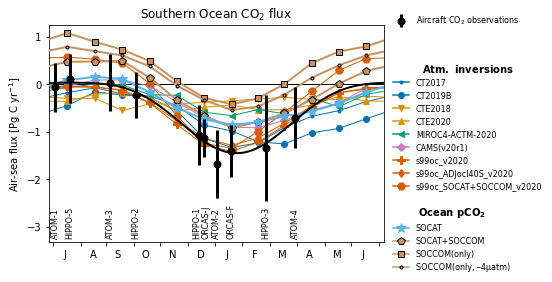

In [8]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)   
h = ec.flux_contraint_seasonal_cycle(ax, ac, dsets_sfco2_mon)


marker_spec = figure_panels.marker_spec_models()
sfco2_ocn_model_list = list(dsets_sfco2_mon.keys())
assert not ('TM5-Flux-mrf' in sfco2_ocn_model_list and 'SOM-FFN' in sfco2_ocn_model_list)
    
spec = {}
legend_elements_inv = []
legend_elements_pco2 = []
for model in sfco2_ocn_model_list:    
    field = 'CO2' if 'CO2' in marker_spec[model] else 'CO2_OCN'
    spec = {k: v for k, v in marker_spec[model][field].items()}
    spec['label'] = ec.flux_label(marker_spec[model][field]['label']) 
    if model in sfco2_ocn_inversions:
        legend_elements_inv.append(Line2D([0], [0], **spec))
    elif model in sfco2_ocn_pco2_clim or model in sfco2_ocn_soccom:
        legend_elements_pco2.append(Line2D([0], [0], **spec))
        

from matplotlib.legend_handler import HandlerErrorbar       
leg0 = ax.legend(handles=[h], labels=['Aircraft CO$_2$ observations'], ncol=1, 
                     handler_map={type(h): HandlerErrorbar(xerr_size=0.8)},
                     handlelength=2,
                     fontsize=8, loc=(1.02, 0.975), frameon=False,)

leg1 = ax.legend(handles=legend_elements_inv, ncol=1, 
          fontsize=8, loc=(1.02, 0.22), frameon=False, title="$\\bf{Atm.\ inversions}$");

leg2 = ax.legend(handles=legend_elements_pco2, ncol=1, 
          fontsize=8, loc=(1.02, -0.15), frameon=False, title='$\\bf{Ocean\ pCO_2}$');

ax.add_artist(leg0)
ax.add_artist(leg1)

ax.set_title('Southern Ocean CO$_2$ flux');

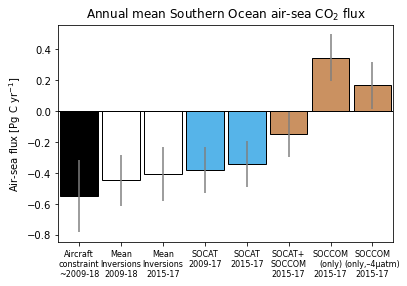

In [9]:
marker_spec = figure_panels.marker_spec_models()

ds_inversion_full_period = xr.concat(
    [dsets_sfco2_ann[m].SFCO2_OCN for m in sfco2_ocn_inversions], 
    dim='model',
)

ds_inversion_full_2015_2017 = xr.concat(
    [dsets_sfco2_ocn[m].SFCO2_OCN.sel(time=slice('2015', '2017')).mean('time') for m in sfco2_ocn_inversions], 
    dim='model',
)

ds_soccom = xr.concat(
    [dsets_sfco2_ann[m].SFCO2_OCN for m in sfco2_ocn_soccom], 
    dim='model',
)

sfco2_ann_estimates = [
    ('Aircraft\nconstraint\n~2009-18', ac.estimate_ann_mean_flux),
    ('Mean\nInversions\n2009-18', (ds_inversion_full_period.mean('model').values, ds_inversion_full_period.std('model').values)),
    ('Mean\nInversions\n2015-17', (ds_inversion_full_2015_2017.mean('model').values, ds_inversion_full_2015_2017.std('model').values)),    
]


som_ffn_method_uncertainty = 0.15

y, _, _ = util.datetime64_parts(dsets_sfco2_ocn['SOM-FFN'].sel(time=slice('2009', '2018')).time)
label = f'SOCAT\n{y[0]}-{y[-1]-2000}'
sfco2_ann_estimates.append(
    (label, (
        dsets_sfco2_ocn['SOM-FFN'].SFCO2_OCN.sel(time=slice('2009', '2018')).mean('time').values, 
        som_ffn_method_uncertainty)
    )
)

y, _, _ = util.datetime64_parts(dsets_sfco2_ocn['SOM-FFN'].sel(time=slice('2015', '2017')).time)
label = f'SOCAT\n{y[0]}-{y[-1]-2000}'
sfco2_ann_estimates.append(
    (label, (
        dsets_sfco2_ocn['SOM-FFN'].SFCO2_OCN.sel(time=slice('2015', '2017')).mean('time').values, 
        som_ffn_method_uncertainty)
    )
)

    
y, _, _ = util.datetime64_parts(dsets_sfco2_ocn[sfco2_ocn_soccom[0]].time)
year_str = f'{y[0]}-{y[-1]-2000}'
for m in sfco2_ocn_soccom:
    label = ec.flux_label(marker_spec[m]['CO2_OCN']['label'], linebreaks=True)
    label = f'{label}\n{year_str}'
    sfco2_ann_estimates.append(
        (
            label, 
            (dsets_sfco2_ocn[m].SFCO2_OCN.mean('time').values, som_ffn_method_uncertainty)
        )
    )
    
sfco2_ann_estimates = OrderedDict(sfco2_ann_estimates)


def ann_mean_flux(ax):
    width = 0.9
    x1 = np.arange(len(sfco2_ann_estimates.keys()))
    y1 = [v[0] for v in sfco2_ann_estimates.values()]
    yerr1 = [v[1] for v in sfco2_ann_estimates.values()]
    labels = list(sfco2_ann_estimates.keys())
    colors = []
    for l in labels:
        if 'Aircraft' in l:
            colors.append('k')
        elif 'Inversion' in l:
            colors.append('w')
        elif 'SOCCOM\n(only)' in l: 
            colors.append(marker_spec['TM5-Flux-mwf']['CO2_OCN']['color'])
        elif '–4µatm' in l: 
            colors.append(marker_spec['TM5-Flux-mmf']['CO2_OCN']['color'])
        elif 'SOCAT' in l and 'SOCCOM' in l: 
            colors.append(marker_spec['TM5-Flux-m0f']['CO2_OCN']['color'])
        elif 'SOCAT' in l:
            colors.append(marker_spec['SOM-FFN']['CO2_OCN']['color'])
        else:
            raise ValueError(f'unknown label: {l}')

    for x, y, yerr, c in zip(x1, y1, yerr1, colors):
        ax.bar(x, 
               y,
               yerr=yerr,
               width=width,
               color=c,
               edgecolor='k',
               error_kw=dict(ecolor='tab:gray')
              )


    ax.axhline(0., lw=1., color='k')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(x1)
    ax.set_xticklabels(labels, fontsize=8)
    #ax.xaxis.tick_top()
    ax.set_ylabel('Air-sea flux [Pg C yr$^{-1}$]');
    ax.set_title('Annual mean Southern Ocean air-sea CO$_2$ flux')
    ylm = ax.get_ylim()
    ax.set_xlim((0-width/2-width*0.05, 7+width/2+width*0.05))
    
    
fig = plt.figure() #figsize=(12, 4))
ax = plt.subplot(1, 1, 1)
ann_mean_flux(ax)

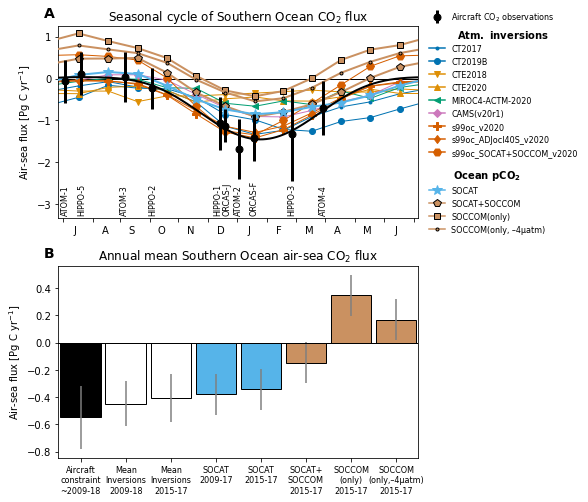

In [10]:
fig = plt.figure(figsize=(5, 6)) #dpi=300)

# set up plot grid
gs = gridspec.GridSpec(
    nrows=2, ncols=1, 
    left=0, right=1,
    bottom=0., top=1,
    hspace=0.25, wspace=0.15,
)

axs = [
    plt.subplot(gs[0, 0]),
    plt.subplot(gs[1, 0]),
]

ann_mean_flux(axs[1])

h = ec.flux_contraint_seasonal_cycle(axs[0], ac, dsets_sfco2_mon)
axs[0].set_title('Seasonal cycle of Southern Ocean CO$_2$ flux')

#l, b, w, h = axs[0].get_position().bounds
#axs[0].set_position([l, b-0.1, w, h])

#axs[0].legend(loc=(1.02, -1), ncol=1, frameon=False)
#axs[0].legend(loc=(1.02, 0), ncol=1, frameon=False)

marker_spec = figure_panels.marker_spec_models()
sfco2_ocn_model_list = list(dsets_sfco2_mon.keys())
if 'TM5-Flux-mrf' in sfco2_ocn_model_list and 'SOM-FFN' in sfco2_ocn_model_list:
    sfco2_ocn_model_list.remove('TM5-Flux-mrf')

spec = {}
legend_elements_inv = []
legend_elements_pco2 = []
for model in sfco2_ocn_model_list:    
    field = 'CO2' if 'CO2' in marker_spec[model] else 'CO2_OCN'
    spec = {k: v for k, v in marker_spec[model][field].items()}
    spec['label'] = ec.flux_label(marker_spec[model][field]['label']) 
    if model in sfco2_ocn_inversions:
        legend_elements_inv.append(Line2D([0], [0], **spec))
    elif model in sfco2_ocn_pco2_clim or model in sfco2_ocn_soccom:
        legend_elements_pco2.append(Line2D([0], [0], **spec))

        
from matplotlib.legend_handler import HandlerErrorbar       
leg0 = axs[0].legend(handles=[h], labels=['Aircraft CO$_2$ observations'], ncol=1, 
                     handler_map={type(h): HandlerErrorbar(xerr_size=0.8)},
                     handlelength=2,
                     fontsize=8, loc=(1.02, 1), frameon=False,)

leg1 = axs[0].legend(handles=legend_elements_inv, ncol=1, 
          fontsize=8, loc=(1.02, 0.3), frameon=False, title="$\\bf{Atm.\ inversions}$");

leg2 = axs[0].legend(handles=legend_elements_pco2, ncol=1, 
          fontsize=8, loc=(1.02, -0.1), frameon=False, title='$\\bf{Ocean\ pCO_2}$');

axs[0].add_artist(leg0)
axs[0].add_artist(leg1)

util.label_plots(fig, axs)

util.savefig(f'Fig-4-fluxes-{constraint_type}.pdf')

In [11]:
da_srf = (
    obs_surface.open_surface_co2_data('obs', 'CO2')
)

da_srf_a = da_srf - da_srf.sel(record=['SPO_NOAA_insitu_CO2']).mean('record')
ds_djf = util.ann_mean(da_srf_a.to_dataset(), season='DJF', time_bnds_varname=None)
ds_jja = util.ann_mean(da_srf_a.to_dataset(), season='JJA', time_bnds_varname=None)

/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragg

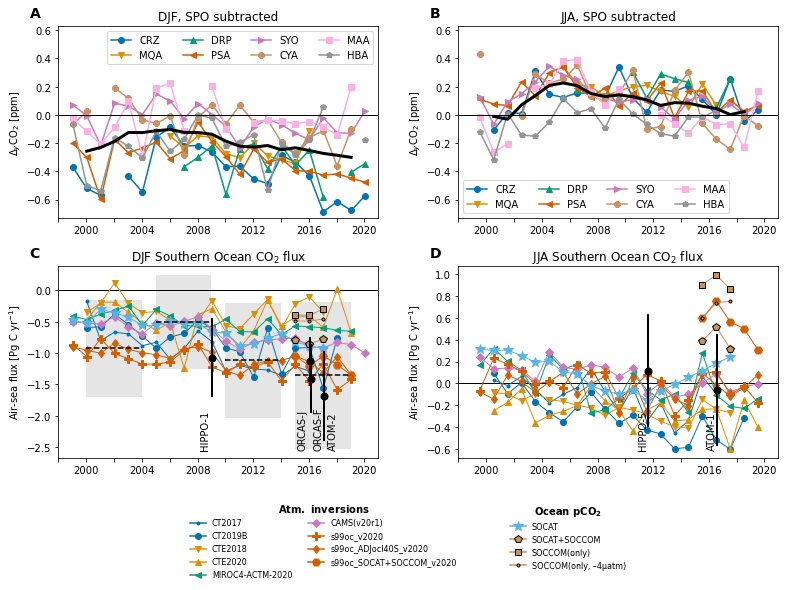

In [12]:
fig = plt.figure(figsize=(10, 6)) #dpi=300)

# set up plot grid
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    left=0, right=1,
    bottom=0., top=1,
    hspace=0.25, wspace=0.25,
)

axs = [
    plt.subplot(gs[0, 0]),
    plt.subplot(gs[1, 0]),
    plt.subplot(gs[0, 1]),
    plt.subplot(gs[1, 1]),        
]


figure_panels.obs_srf_trends_djf_jja([axs[0], axs[2]],
    ds_djf.CO2.groupby('stncode').mean('record').sel(stncode=obs_surface.southern_ocean_stn_list), 
    ds_jja.CO2.groupby('stncode').mean('record').sel(stncode=obs_surface.southern_ocean_stn_list),
)

ndx = [(sc.period_str(p), 'DJF') for p in pentads]

ec.flux_contraint_djf_timeseries(axs[1], dsets_sfco2_mmm, ac, sc.surface_flux.loc[ndx])
axs[1].set_title('DJF Southern Ocean CO$_2$ flux')
#axs[2].set_ylabel('')

spec = {}
legend_elements_inv = []
legend_elements_pco2 = []
for model in sfco2_ocn_model_list:    
    field = 'CO2' if 'CO2' in marker_spec[model] else 'CO2_OCN'
    spec = {k: v for k, v in marker_spec[model][field].items()}
    spec['label'] = ec.flux_label(marker_spec[model][field]['label']) 
    if model in sfco2_ocn_inversions:
        legend_elements_inv.append(Line2D([0], [0], **spec))
    elif model in sfco2_ocn_pco2_clim or model in sfco2_ocn_soccom:
        legend_elements_pco2.append(Line2D([0], [0], **spec))
    
leg1 = axs[1].legend(handles=legend_elements_inv, ncol=2, 
          fontsize=8, loc=(0.4, -0.65), frameon=False, title="$\\bf{Atm.\ inversions}$");

leg2 = axs[1].legend(handles=legend_elements_pco2, ncol=1, 
          fontsize=8, loc=(1.4, -0.6), frameon=False, title='$\\bf{Ocean\ pCO_2}$');

axs[1].add_artist(leg1)
#axs[2].legend(loc=(0., -2.1), ncol=2, frameon=False)


ec.flux_contraint_jja_timeseries(axs[3], dsets_sfco2_mmm, ac)
axs[3].set_title('JJA Southern Ocean CO$_2$ flux')
#axs[3].set_ylabel('')


for ax in axs:
    ax.set_xticks(np.arange(1998, 2022, 2));
    ticklabels = np.arange(1998, 2022, 2).astype(str)
    ticklabels[::2] = ''
    ax.set_xticklabels(ticklabels)
    ax.set_xlim([1998, 2021])
        
util.label_plots(fig, [axs[i] for i in [0, 2, 1, 3]])

util.savefig(f'Fig-S12-flux-timeseries-{constraint_type}.pdf')